In [240]:
import emoji
import numpy as np
import pandas as pd
from keras.layers import LSTM, Activation, Dense, Dropout, Embedding, Input
from keras.models import Model
from keras.utils import to_categorical
from utils_ml import *
from utils_prj import *

%matplotlib inline

## Load Data

In [280]:
data_train = pd.read_csv('data/train_emoji.csv', names=['tweet', 'class', 'col3', 'col4']).drop(columns=['col3', 'col4'])
data_test = pd.read_csv('data/test_emoji.csv', names=['tweet', 'class'])
print(data_train.shape)
print(data_test.shape)
print(data_train['class'].unique())
print(data_test['class'].unique())
data_train.head()

(132, 2)
(56, 2)
[3 2 0 4 1]
[4 3 2 0 1]


,tweet,class
0,never talk to me again,3
1,I am proud of your achievements,2
2,It is the worst day in my life,3
3,Miss you so much,0
4,food is life,4


In [298]:
X_train, Y_train = data_train['tweet'].to_numpy(), data_train['class'].to_numpy()
X_test, Y_test = data_test['tweet'].to_numpy(), data_test['class'].to_numpy()

# max length of tweets, used to define NN Input layer size (should be fixed size)
max_len = len(max(X_train, key=len).split())
print('tweet with max len: "{}"'.format(max(X_train, key=len)))
print('max_len: ', max_len)

# one-hot encode Y
Y_train_oh = to_categorical(Y_train, num_classes=5)
Y_test_oh = to_categorical(Y_test, num_classes=5)




tweet with max len: "I am so impressed by your dedication to this project"
max_len:  10


In [115]:
# the set of emoji used
print('Emoji in the dataset:')
for k, v in emoji_dictionary.items():
    print(k, v, emoji.emojize(emoji_dictionary[k], variant='text_type'))

print('\nExamples:')
for idx in range(10):
    print(X_train[idx], Y_train[idx], label_to_emoji(str(Y_train[idx])))

Emoji in the dataset:
0 :red_heart: ❤︎
1 :baseball: ⚾︎
2 :grinning_face: 😀
3 :disappointed_face: 😞
4 :fork_and_knife: 🍴

Examples:
never talk to me again 3 😞
I am proud of your achievements 2 😀
It is the worst day in my life 3 😞
Miss you so much 0 ❤︎
food is life 4 🍴
I love you mum 0 ❤︎
Stop saying bullshit 3 😞
congratulations on your acceptance 2 😀
The assignment is too long  3 😞
I want to go play 1 ⚾︎


## Load Word Embeddings

In [80]:
# load word embendings GloVe
word_to_index, index_to_word, word_to_vec_map = load_glove_embeddings(file_path='data/glove.6B.50d.txt')

w = 'angeles'
idx = 930
print(word_to_index[w])
print(index_to_word[idx])
print(word_to_vec_map[w])


930
angeles
[-1.7063e-01  8.2230e-01 -5.8367e-02  8.3355e-01 -2.8705e-01 -6.0105e-01
 -1.6279e+00  2.1288e-03 -3.0087e-01  4.5756e-01 -4.9159e-01 -7.5213e-01
 -3.9453e-01  4.9286e-01  7.2132e-01 -7.9924e-01 -5.0742e-01 -2.1675e-01
 -9.1558e-01  2.2442e-01 -7.9669e-02  5.1341e-01 -8.4589e-01  4.0118e-01
 -1.0337e+00 -1.2526e+00  1.4268e-01  8.7244e-04  1.1365e-01 -1.1600e+00
  2.3215e+00 -2.0916e-01  3.2530e-01 -1.5588e+00 -3.4905e-01 -3.2448e-01
  2.4880e-01 -2.5748e-01  1.0241e+00  4.0609e-02 -5.2181e-01  3.8599e-01
  4.9987e-01 -1.7234e-02 -4.0238e-01  2.5682e-01 -5.1268e-01 -5.9622e-01
 -2.0733e-01  1.3045e+00]


## Build Base Model

### Some tests

In [299]:
# 1 how sentence_to_avg() works
#sentence_to_avg(sentence='I love apples', word_to_vec_map=word_to_vec_map)

# 2 test basic model
#test_model_basic(target=build_model_basic)

### Build and Fit Basic Model

Before logging experiments:
```
mlflow server --backend-store-uri ./mlruns --default-artifact-root ./mlruns --port 5000
```
If we need to clean processes on running on the port:
```
lsof -i :5000
kill -9 <PID1> <PID2> <PID3> ...
```


In [322]:
import os

# Set environment variables before importing TensorFlow
os.environ['PYTHONHASHSEED'] = str(0)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Limit threading for reproducibility
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

# Now import TensorFlow

# Set random seeds
# np.random.seed(0)
# tf.random.set_seed(1)


any_word = list(word_to_vec_map.keys())[0]
nx = word_to_vec_map[any_word].shape[0]
ny = 5

accuracy_train_arr = []
accuracy_test_arr = []
accuracy_eval_arr = []
for i in range(1, 10, 1):
    print(f'Run #{i}')
    model_basic = build_model_basic(input_shape = (nx,), output_shape=ny)
    accuracy_train, accuracy_test, accuracy_eval = run_model(model=model_basic, 
                                                             X_train = X_train, 
                                                             Y_train = Y_train, 
                                                             X_test = X_test, 
                                                             Y_test = Y_test,
                                                             func_prepare_XY=prepare_XY_model_basic,
                                                             experiment_name='exp__emoji__model_basic', 
                                                             run_id=i)
    accuracy_train_arr.append(accuracy_train)
    accuracy_test_arr.append(accuracy_test)
    accuracy_eval_arr.append(accuracy_eval)

print('accuracy_train_arr: ', accuracy_train_arr)
print('accuracy_test_arr: ', accuracy_test_arr)
print('accuracy_eval_arr: ', accuracy_eval_arr)




Run #1
All .png files have been deleted.


## Advanced model (RNN, LSTM)

<img src="images/emojifierv2.png" style="width:700px;height:400px;"> <br>

In [276]:
maxLen = 10
model_rnn = build_model_rnn((maxLen,), word_to_vec_map)
# print(model_rnn.summary())

# compile model
model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# prepare X_train: convert words to indexes
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)

history_model_rnn = model_rnn.fit(X_train_indices, Y_train_oh, epochs = 100, batch_size = 32, shuffle=True)


Model: "functional_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_76 (InputLayer)     │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 10, 50)         │    20,000,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 10, 128)        │        91,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 5)              │           645 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,223,927 (77.15 MB)

 Trainable params: 223,877 (874.52 KB)

 Non-trainable params: 20,000,050 (76.29 MB)

In [278]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
loss, acc = model_rnn.evaluate(X_test_indices, Y_test_oh)
print("Test accuracy = ", acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6146 - loss: 2.7133  
Test accuracy =  0.625


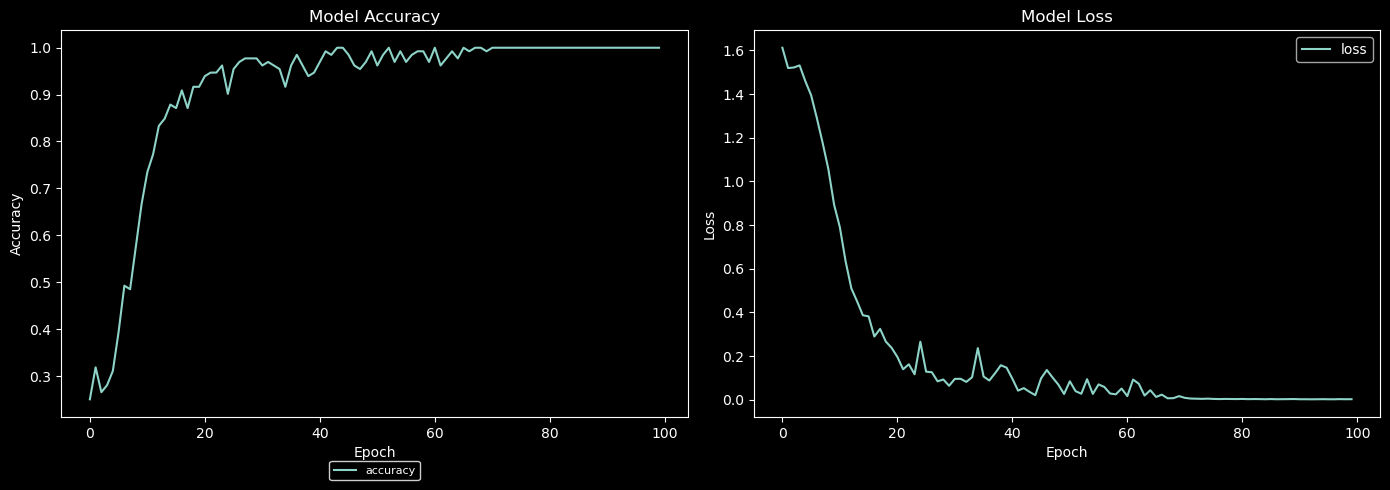

In [279]:
history_df = pd.DataFrame(history_model_rnn.history)
plot_metrics_vs_epoch(history_df, file_name='model_fit_history.png')

### Predict on the Test

In [294]:
# predict on test
print('Predict on test')
pred_test = model_rnn.predict(X_test_indices)
pred_test = np.argmax(pred_test, axis=1)
accuracy_test = (pred_test == Y_test).mean()
print(pred_test)
print('Accuracy (test): ', accuracy_test)
print()

# predict on train
print('Predict on train: ')
pred_train = model_rnn.predict(X_train_indices)
pred_train = np.argmax(pred_train, axis=1)
accuracy_train = (pred_train == Y_train).mean()
print(pred_train)
print('Accuracy (train): ', accuracy_train)

Predict on test
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
[4 3 1 2 2 2 3 2 4 2 1 2 0 2 1 3 3 2 1 2 0 0 4 3 3 3 2 0 1 2 0 1 3 2 0 1 2
 3 4 2 1 0 0 1 2 0 3 2 3 1 3 0 3 2 3 2]
Accuracy (test):  0.625

Predict on train: 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[3 2 3 0 4 0 3 2 3 1 3 3 1 3 2 3 2 3 1 2 3 0 2 2 2 1 4 2 2 4 0 3 4 2 0 3 2
 2 3 4 2 2 0 2 3 0 3 2 4 3 0 3 3 3 4 2 1 1 1 2 3 1 0 0 0 3 4 4 2 2 1 2 0 3
 2 2 0 0 3 1 2 1 2 2 4 3 3 2 4 0 0 0 3 3 3 2 0 1 2 3 0 2 2 2 3 2 2 2 4 1 1
 3 3 4 1 2 1 1 3 1 0 4 0 3 3 4 4 1 4 3 0 2]
Accuracy (train):  1.0


In [274]:
# This code allows you to see the mislabelled examples
for i in range(len(X_test)):
    x = X_test_indices
    if(pred_test[i] != Y_test[i]):
        print('Expected: '+ label_to_emoji(Y_test[i]) + f'({Y_test[i]}), prediction: ' + label_to_emoji(pred_test[i]).strip() + f'({pred_test[i]}), sentence: ' + X_test[i])

Expected: 😀(2), prediction: ⚾︎(1), sentence: he got a raise	
Expected: ❤︎(0), prediction: 😀(2), sentence: she got me a present	
Expected: ❤︎(0), prediction: 😀(2), sentence: he is a good friend	
Expected: ❤︎(0), prediction: 😞(3), sentence: I am upset	
Expected: ❤︎(0), prediction: 😀(2), sentence: We had such a lovely dinner tonight	
Expected: 😞(3), prediction: 😀(2), sentence: work is hard	
Expected: 😞(3), prediction: ❤︎(0), sentence: This girl is messing with me	
Expected: 😀(2), prediction: 😞(3), sentence: are you serious ha ha	
Expected: 😞(3), prediction: 😀(2), sentence: work is horrible	
Expected: 😞(3), prediction: ⚾︎(1), sentence: stop messing around	
Expected: 🍴(4), prediction: 😀(2), sentence: any suggestions for dinner	
Expected: ❤︎(0), prediction: 😞(3), sentence: I love taking breaks	
Expected: 😀(2), prediction: ❤︎(0), sentence: you brighten my day	
Expected: 😞(3), prediction: ❤︎(0), sentence: she is a bully	
Expected: 😞(3), prediction: 😀(2), sentence: I worked during my birthday	


### Add more training examples

In [293]:
tweets = X_train

# Generate augmented dataset
X_train_augmented = []
Y_train_augmented = []
 
for tweet, label in zip(X_train, Y_train):
    print('tweet, label: ', tweet, label)
    X_train_augmented.append(tweet)  # Original
    Y_train_augmented.append(label)
    augment_sentences = augment_sentence(tweet)
    X_train_augmented.extend(augment_sentences)  # Augmented versions
    Y_train_augmented.extend([label]*len(augment_sentences))


#pd.DataFrame({'X_train': X_train_augmented, 'Y_train': Y_train_augmented}).head(20)

tweet, label:  never talk to me again 3
*** augment_sentence ***
sentence:  never talk to me again
tweet, label:  I am proud of your achievements 2
*** augment_sentence ***
sentence:  I am proud of your achievements
tweet, label:  It is the worst day in my life 3
*** augment_sentence ***
sentence:  It is the worst day in my life
tweet, label:  Miss you so much 0
*** augment_sentence ***
sentence:  Miss you so much
tweet, label:  food is life 4
*** augment_sentence ***
sentence:  food is life
tweet, label:  I love you mum 0
*** augment_sentence ***
sentence:  I love you mum
tweet, label:  Stop saying bullshit 3
*** augment_sentence ***
sentence:  Stop saying bullshit
tweet, label:  congratulations on your acceptance 2
*** augment_sentence ***
sentence:  congratulations on your acceptance
tweet, label:  The assignment is too long  3
*** augment_sentence ***
sentence:  The assignment is too long 
tweet, label:  I want to go play 1
*** augment_sentence ***
sentence:  I want to go play
twee

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/andreikristov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/andreikristov/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,X_train,Y_train
0,never talk to me again,3
1,never verbalise to Pine Tree State again,3
2,never talk talk to me again,3
3,never to talk me again,3
4,never talk to me again,3
5,I am proud of your achievements,2
6,I am gallant of your accomplishment,2
7,I am proud of your achievements,2
8,I am proud of achievements your,2
9,I proud of your achievements,2
